## This is a project which is used to train data sets of photos taken by simulation cars by neural network, and then predict steer angle of the simulation cars

In [1]:
import numpy as np
import pandas as pd
import os
import json
from skimage.exposure import adjust_gamma
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scipy import ndimage
from scipy.misc import imresize

Using TensorFlow backend.


### First of all, we need to read the driving_log file to read images names, and then get the images from IMG file

In [64]:
angles = pd.read_csv('../driving_log.csv',header=None)
angles = np.array(angles[3])
recovery_angles = pd.read_csv('../Recovery/driving_log.csv', header = None)
recovery_angles = np.array(recovery_angles[3])

In [74]:
angles

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [76]:
from process_image import process_data
(center,right,left)=process_data(csv_file="../IMG", angles)

SyntaxError: positional argument follows keyword argument (<ipython-input-76-baef701f52d5>, line 2)

In [8]:
(center,right)

In [9]:
count = 0
for image in images:
    image_file = os.path.join('../IMG', image)
    if image.startswith('center'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        center[count % len(angles)] = imresize(image_data, (32,64,3))#[12:,:,:]
    elif image.startswith('right'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        right[count % len(angles)] = imresize(image_data, (32,64,3))#[12:,:,:]
    elif image.startswith('left'):
        image_data = ndimage.imread(image_file).astype(np.float32)
        left[count % len(angles)] = imresize(image_data, (32,64,3))#[12:,:,:]
count += 1

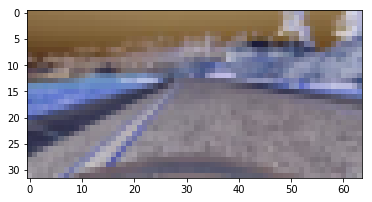

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
plt.imshow(center[0])

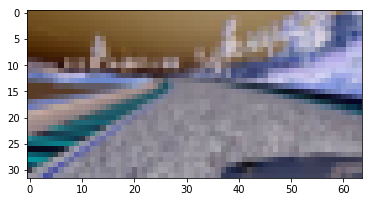

In [11]:
plt.imshow(left[0])

In [19]:
recovery_images = np.asarray(os.listdir("../Recovery/IMG/"))
recovery = np.ndarray(shape=(len(recovery_images), 32, 64, 3))

# Populate recovery driving dataset
count = 0
for image in recovery_images:
    image_file = os.path.join('../Recovery/IMG', image)
    image_data = ndimage.imread(image_file).astype(np.float32)
    recovery[count] = imresize(image_data, (32,64,3))
    count += 1

In [30]:
recovery_images.shape

(3846,)

In [37]:
X_train = np.concatenate((center, right, left, recovery[0:1012]), axis=0)
y_train = np.concatenate((angles, (angles - .08), (angles + .08), recovery_angles[0:1012]),axis=0)

In [38]:
mirror = np.ndarray(shape=(X_train.shape))
count = 0
for i in range(len(X_train)):
    mirror[count] = np.fliplr(X_train[i])
    count += 1
mirror.shape

(4072, 32, 64, 3)

In [39]:
mirror = np.ndarray(shape=(X_train.shape))
count = 0
for i in range(len(X_train)):
    mirror[count] = np.fliplr(X_train[i])
    count += 1
mirror.shape


(4072, 32, 64, 3)

In [41]:
mirror_angles = y_train * -1
X_train = np.concatenate((X_train, mirror), axis=0)
y_train = np.concatenate((y_train, mirror_angles),axis=0)

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.05)

In [43]:
# Establish model architecture
model = Sequential()
model.add(BatchNormalization(axis=1, input_shape=(32,64,3)))
model.add(Convolution2D(16, 3, 3, border_mode='valid', subsample=(2,2), activation='relu'))
model.add(Convolution2D(24, 3, 3, border_mode='valid', subsample=(1,2), activation='relu'))
model.add(Convolution2D(36, 3, 3, border_mode='valid', activation='relu'))
model.add(Convolution2D(48, 2, 2, border_mode='valid', activation='relu'))
model.add(Convolution2D(48, 2, 2, border_mode='valid', activation='relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Dropout(.5))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(1))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_1 (BatchNorma (None, 32, 64, 3)     128         batchnormalization_input_1[0][0] 
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 15, 31, 16)    448         batchnormalization_1[0][0]       
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 13, 15, 24)    3480        convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 11, 13, 36)    7812        convolution2d_2[0][0]            
___________________________________________________________________________________________

In [45]:
adam = Adam(lr=0.0001)
model.compile(loss='mse',optimizer=adam)

In [46]:
checkpoint = ModelCheckpoint(filepath = 'model.h5', verbose = 1, save_best_only=True, monitor='val_loss')

In [47]:
callback = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [49]:
model.fit(X_train,
        y_train,
        nb_epoch=20,
        verbose=1,
        batch_size=128,
        shuffle=True,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, callback])

#print("Weights Saved")
json_string = model.to_json()
with open('model.json', 'w') as jsonfile:
    json.dump(json_string, jsonfile)
print("Model Saved")

Train on 7736 samples, validate on 408 samples
Epoch 1/20
7736/7736 [==============================] - 21s - loss: 0.0558 - val_loss: 0.0607
Epoch 2/20
7736/7736 [==============================] - 20s - loss: 0.0541 - val_loss: 0.0607
Epoch 3/20
7736/7736 [==============================] - 20s - loss: 0.0541 - val_loss: 0.0607
Epoch 4/20
7736/7736 [==============================] - 20s - loss: 0.0541 - val_loss: 0.0607
Epoch 5/20
7736/7736 [==============================] - 20s - loss: 0.0541 - val_loss: 0.0607
Epoch 00004: early stopping
Model Saved


### After getting our images, we need to construct our neural network structure

In [7]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
import cv2, numpy as np

Using TensorFlow backend.


### Then,we need to build a neural network, first let's modify the VGG net from the Keras, and extend it to a new model so that we can use it for my project! Some codes are referenced from https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3 for the implementation of VGG_16 

In [17]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        model.load_weights(weights_path)

    return model